# Machine learning process for supervised machine learning with application in insurance pricing (in Python)

### Abstract

In order to highlight the use of some of the most well-known supervised machine learning, we propose to consider here an insurance application. This notebook is dedicated to the application of **supervised machine learning techniques to the non-life pricing** of insurance cover.

### Disclaimer

This notebook has been developed for the purpose of Reacfin Academy only. Any reproduction and any use of copies carried out at other ends is strictly prohibited.

# Table of contents <a name="tab"></a>

* [Chapter 1 - Environment and data](#one)
    + [1.1 Python](#one-one)
    + [1.2 Libraries](#one-two)
    + [1.3 Presentation of the data](#one-three)
    + [1.4 Data Import](#one-four)


* [Chapter 2 - Machine Learning context](#two)
    + [2.1 Identification of the problem](#two-one)
    + [2.2 Data preparation](#two-two)
    + [2.3 Data split : Training and testing sets](#two-three)
    + [2.4 Define the model error](#two-four)
    + [2.5 Computation of the flat model](#two-five)
    
    
* [Chapter 3 - Regression trees](#three)
    + [3.1 Training ](#three-one)
    + [3.2 Cross-validation](#three-two)
        + [3.2.1 Simple example](#three-two-one)
        + [3.2.2 Samples per leaf](#three-two-two)
    + [3.3 Variable importance measure](#three-three)
    + [3.4 Partial dependence](#three-four)
        
* [Chapter 4 - Random forests](#four)
    + [4.1 Training](#four-one)
    + [4.2 Cross-validation](#four-two)
    + [4.3 Variable importance measure](#four-three)
    + [4.4 Partial dependence](#four-four)
    
* [Chapter 5 - Gradient boosting](#five)
    + [5.1 Training](#five-one)
    + [5.2 Cross-validation](#five-two)
    + [5.3 Variable importance measure](#five-three)
    + [5.4 Partial dependence](#five-four)
    
* [Chapter 6 - Next steps](#six)    

## Chapter 1 - Environment and data <a name="one"></a>

In this chapter we will introduce the
* The environment used, i.e. Python version and libraries, and
* The data.

### 1.1 Python <a name="one-one"></a>

For this tutorial, we make use of **Python 3** (any version greater than 3.7 should be fine). You can download the latest version [here](https://www.python.org/downloads/). 

To find out which version of Python you are using, use this code :

In [1]:
import sys 
print("User Current Version:-", sys.version)

User Current Version:- 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


We recommend to use the Python library installer called **pip**. pip is already installed with Python's version greater than 3.4 downloaded from [python.org](https://www.python.org/). You can take a look [here](https://pip.pypa.io/en/stable/installation/) for more information on **pip**.

*N.B.: We refer you to the Introduction to Python notebook for basic use of Python.*

### 1.2 Libraries <a name="one-two"></a>

In this notebook, we will mainly use the following libraries :

| Library | Definition | Url | pip command | Installed version |
|----|----|----|----|----|
| matplotlib | Python 2D plotting library that contains many submodules like pyplot, a matlab-like interface | https://matplotlib.org/index.html | pip install matplotlib | 3.4.2 |
| numpy | Fundamental package for scientific computing. Numpy allows the user to integrate C/C++ and Fortran code to Python projects | http://www.numpy.org/ | already included | 1.22.3 |
| pandas | Provides high-performance, easy-to-use data structures and data analysis tools | https://pandas.pydata.org/ | pip install pandas | 1.3.1 |
| scikit-learn | Widely used machine learning library with classification, regression, clustering, model selection, preprocessing etc. | http://scikit-learn.org/stable/ | pip install scikit-learn | 1.0.2 |

The *Installed version* number is not mandatory but be aware that the results might differ if you use another version of those libraries.

As a reminder, the **pip** command is what you will have to write in the command prompt in order to install the library.  A way to access the command prompt on Windows is to use the following shortcut: **Win + R keys $\rightarrow$ "cmd" $\rightarrow$ Enter key**.

After installing the libraries through the use of pip, we still have to import them in the notebook. We can use the `import` statement.

In [2]:
import time #time-related functions
#import os #operating system-dependent functionality

Basically, we know that we will have to use *pandas* library many times. To **improve the code readability**, we will also use the command `import pandas as pd`. This means that we will be able to use a pandas function using `pd.name_of_a_function`. We will apply the same manipulation for other packages as well such as package *numpy*.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

from IPython.display import Image

### 1.3 Presentation of the data <a name="one-three"></a>

In order to highlight pros and cons of the supervised machine learning techniques we present in this notebook, we consider a simulated car insurance database. 

This database was sampled by using the following process :

- 1) We simulate randomly ages of policyholders and powers of cars (i.e. features $\text{age}$ and $\text{power}$) where each pair of ages and powers represents a policyholder.

- 2) We compute the Poisson parameter $\lambda$ designed as a function of ages and powers for each policyholder. 
    
- 3) When for each policyholder we have computed an expected number of claims $\lambda$, we simulate the number of claims for this policyholder thanks to a Poisson distribution with mean $\lambda$.

The simulated database therefore contains 3 simulated variables:

| Variable name | Variable description |
| --- | --- | 
| age | Age of the policyholder |
| power | Power of the car |
| N | Number of claims simulated thanks to a Poisson distribution |

Now, let's talk about the the Poisson parameter, representing the frequency of expected claims $\lambda$. The Poisson parameter has the following properties:
* The first term is quadratic in the variable age,
* The second term is linear in the power, and
* The third term is a non-linear interaction between the two variables (as illustrad in the following figure).

For each pair of ages and powers, we compute the frequency (i.e. the response $\lambda$) by means of the following formula

\begin{equation}
\lambda = a \times (\text{age} - b)^2 + c \times \text{power} + d \times \textbf{I}_{\{\text{age} \geq 60\} \cap \{\text{power} \geq 50\}}
\end{equation}

where $a,b,c,d$ are positive real parameters calibrated in such a way that the range of $\lambda$ is consistent with a frequency range.

In [4]:
def freq(age, power):
    """ Poisson frequency depending of the age and power according to the previous equation.
    Args : 
        age : age of the policyholder
        power : power of the car
    """
    wo_inter = 1e-4 * (age - 50)**2 + 2e-3 * power
    wi_inter = wo_inter + 1e-1 * (1 if age >= 60 and power >= 50 else 0)
    return  wi_inter * 0.9028869

Let's have a look to the dependence structure between the Poisson parameter and the variables ages and powers

In [5]:
ages = np.arange(20, 81)
powers = np.arange(10, 71)

In [6]:
freqs = np.empty([61, 61])

In [7]:
for i in np.arange(0, 61):
    for j in np.arange(0, 61):
        freqs[i, j] = freq(ages[i], powers[j])

To see this structure of dependence, we can plot a surface plot. The surface plot shows a functional relationship between a designated dependent variable (frequency parameter $\lambda$), and two independent variables (ages and powers)

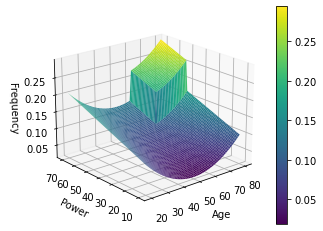

In [8]:
#3D Surface plots
fig = plt.figure()
names = ["Age", "Power", "Frequency"]

#create a rectangular grid out of two given one-dimensional arrays
XX, YY = np.meshgrid(ages, powers)

Z = freqs.T #transpose of this matrix

ax = plt.subplot(projection="3d") #3D Axes

# Plot the surface
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.viridis)

#Label the axes
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel(names[2])

#Add a colorbar
ax.view_init(elev=20, azim=230) #used to rotate the axes programmatically.
plt.colorbar(surf)

#Saving the plot
plt.savefig('www/freqs_3d.png')

#Show the plot
plt.show()

The surface plot is a companion plot to the contour plot. The contour plot represents a 3-dimensional surface on a 2-dimensional format (isolines of matrix Z , where Z contains height values on the x-y plane).

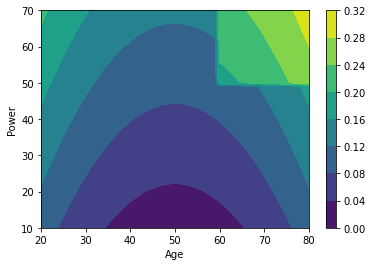

In [9]:
fig=plt.figure()
names = ["Age", "Power"]

ax=plt.subplot() #2D Axes

#Plot the contour
cp = ax.contourf(XX, YY, Z)

#Label the axes
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])

#Add a colorbar
plt.colorbar(cp) 

#Saving the plot
plt.savefig('www/freqs_contour.png')

#Show the plot
plt.show()

{The simulated database we will use contains 20.000 observations.

Working with a simulated database is convenient as :
* we know in advance the pattern to be found in the data,
* we design it such that it includes some specificities which are difficult to learn by some algorithms, and
* we can have as much data as needed to apply a training-validation sets approach or cross-validation.

We focus on modelling the __claims frequency__ (number of claims per year). Each line of the database corresponds to the observation of a policyholder over 1 year. The exposure time to the risk of claims is the same for all policyholders and equal to 1. In some examples, the exposure time may be different for each policyholder. The optimal way to model the number of claims would be to specify an exposure offset:

$$ N_i \sim\mathcal{Poi}(d_i*\lambda_i) $$ 
where :
- $N_i$ represents the number of claims for the $i^{th}$ policyholder
- $d_i$ represents the exposure time for the $i^{th}$ policyholder
- $\lambda_i$ represents the expected frequency of claims for the $i^{th}$ policyholder

In our example, the exposure time is equal to 1 for all policyholders so we have :
$$ N_i \sim\mathcal{Poi}(\lambda_i) $$ 

This model for the frequency has been chosen to fail standard statistical methods (such as Generalized Linear Models) and therefore shows how some machine learning methods can fix these issues.

A first analysis of the simulated database shows that we indeed observe a quadratic trend in age and a linear trend in power with a jump in the values of the interaction (age 60 and power 50).


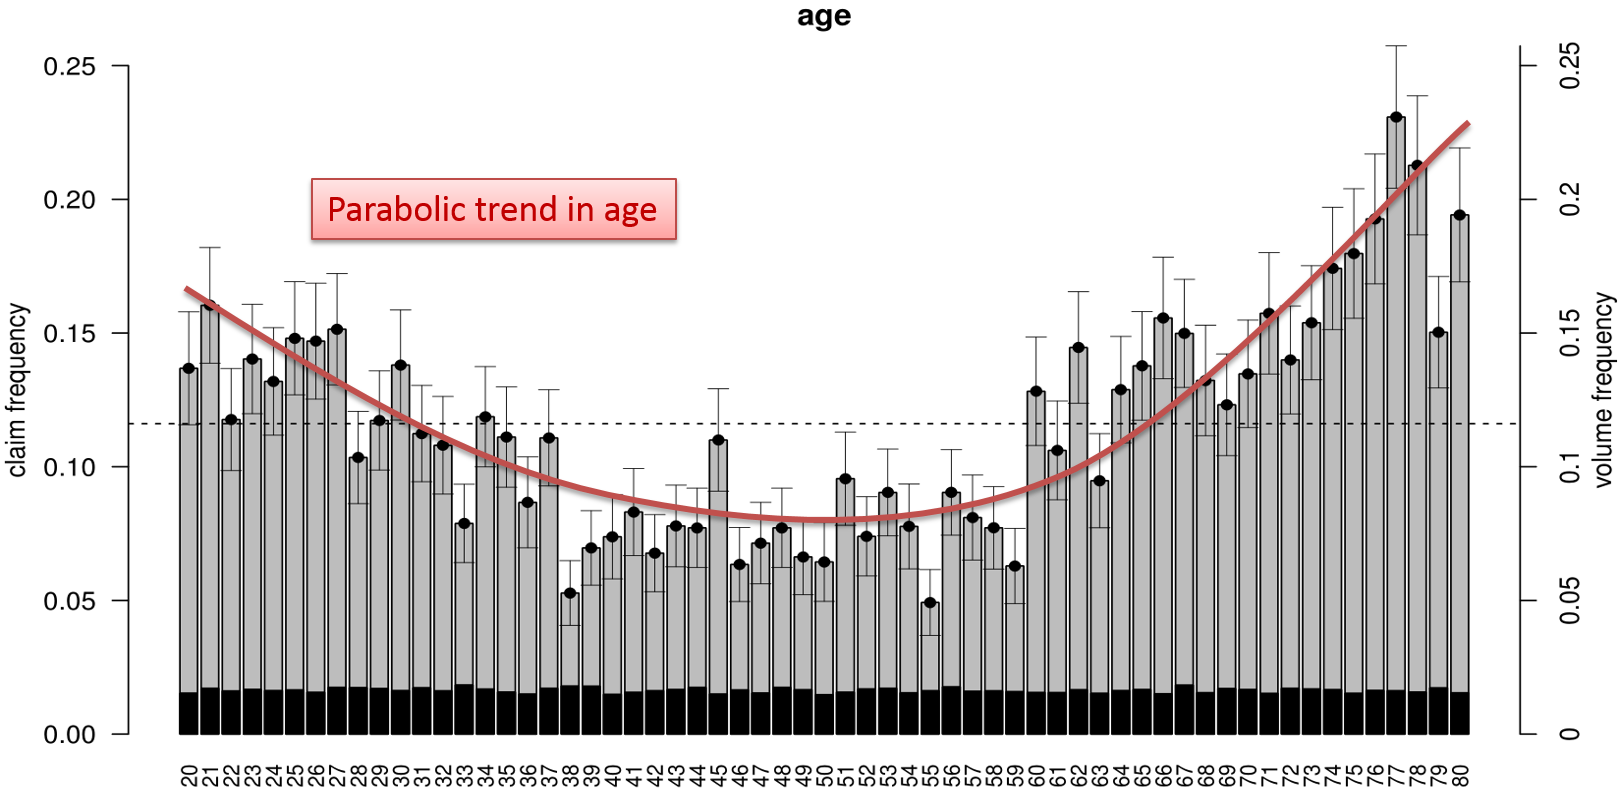

In [10]:
Image("www/age_uni.png")

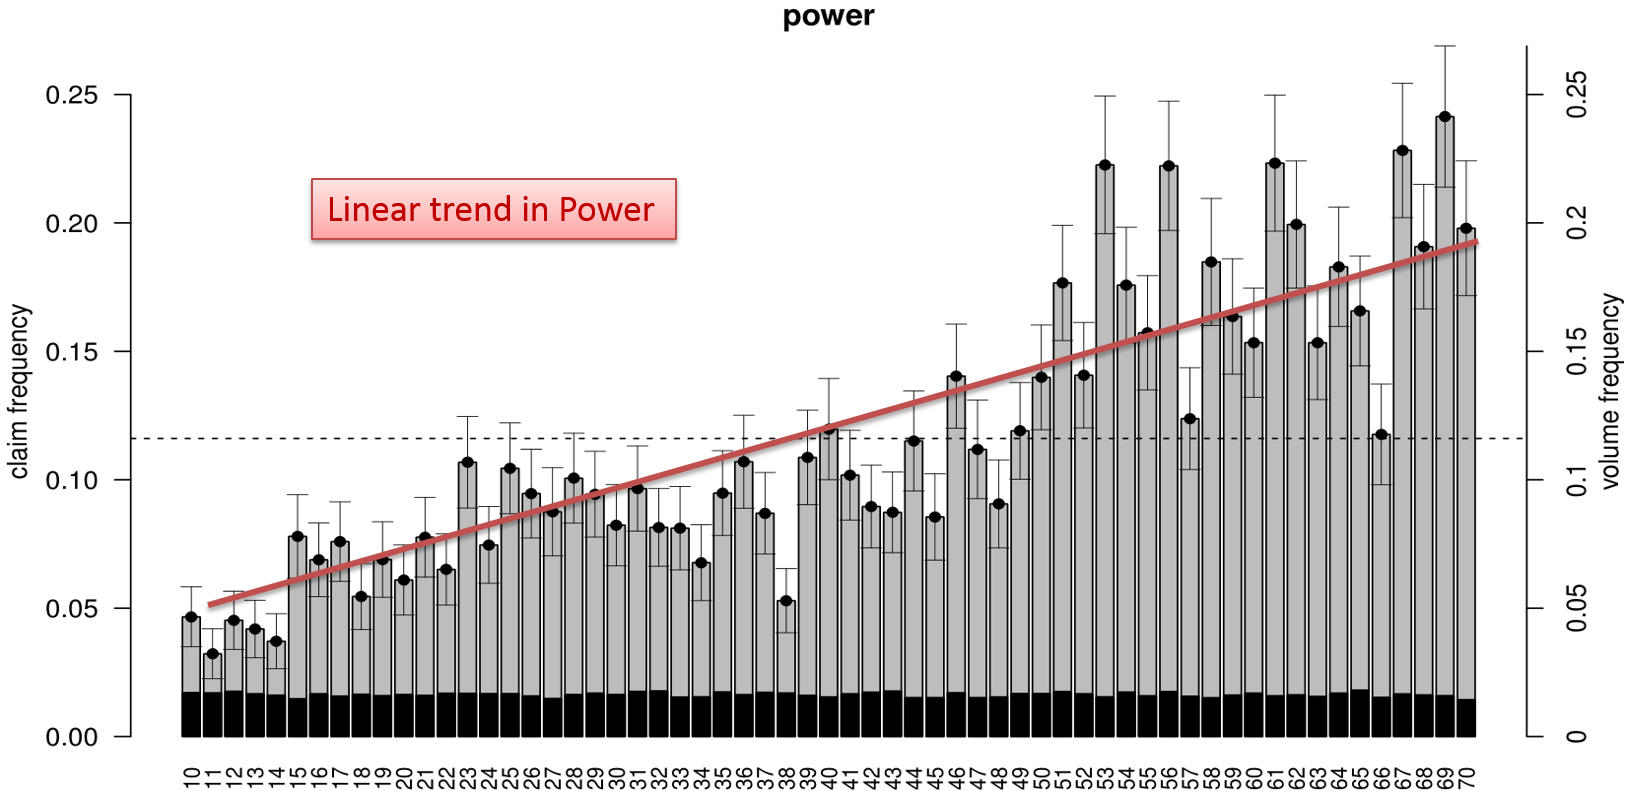

In [11]:
Image("www/power_uni.png")

### 1.4 Data Import <a name="one-four"></a>

The dataset is called **sim_db.csv** and is located in the folder **www** on the server. It is a CSV file, which means that separators are comas.


If we want to load this file in Python, we can use the function `read_csv()` which belongs to the pandas library (which we abbreviated to `pd`).

In [12]:
df = pd.read_csv('www/sim_db.csv')

Many functions can be applied to have a first quick overview of the data. Let us display, for example, the **five first rows** using the `head()` function.

In [13]:
df.head(5)

,age,power,N
0,79,38,0
1,53,29,0
2,41,32,0
3,20,24,0
4,54,12,0


We observe the following variables in the database
 * `age`: the age of the policyholder,
 * `power`: the power of the car, and
 * `N`: the number of claims reported by policyholders.

## Chapter 2 -  Machine Learning context <a name="two"></a>

### 2.1. Identification of the problem <a name="two-one"></a>

**- What is the problem?** 

Nowadays, insurance companies must put forward products at competitive prices that must be continuously adapted in order to keep the pace with the rapidly changing environment of finance and financial markets. In our case, we want to model the frequency of claims for a car insurance portfolio, an essential parameter related to the insurance price.

**- Why does this problem need to be solved?**

Non-Life insurance is facing many challenges ranging from fierce competition on the market and evolution in the distribution channels used by the consumers, to evolution of the regulatory environment.

Pricing is the central link between solvency, profitability and market shares (volume). Improving pricing practice encompasses several dimensions
* Technical,
* Competition,
* Elasticity, and
* Segmentation.

**- How to solve the problem?**

In this business case, we will focus on the first dimension by considering different ML methods that can be used to build a technical tariff. The technical tariff aims at evaluate as accuratly as possible the risk of each policyholder (frequency of claims) according to some charateristics linked to this policyholder (age of the driver and the power of the car). We will test different algorithms to model this response variable (frequency of claims). The models tested are classical statistical techniques: regression trees, bagging and gradient 
boosting method. 

### 2.2. Data preparation<a name="two-two"></a>

For educational reasons, we have simulated a simplified car insurance portfolio rather than using real observations. Working with a simulated database is convenient as we know in advance the pattern found in the data to analyse the results of the models and we have as much data as is needed. So there is no need for data preparation.

Before building a machine learning model it is often a good idea to inspect the data. Inspecting your data is a good way to find abnormalities and peculiarities.

We determine if any values is missing in the dataset by using the method `isnull().values.any()` on the dataframe.

In [14]:
df.isnull().values.any()

False

Let's start with basic descriptive statistics to have an insight into the data. The method `describe()` applied in the dataframe returns an object that holds the following descriptive statistics:

    count: the number of not-empty values in your dataset per variable
    mean: the mean of your dataset per variable
    std: the variance of your dataset per variable
    min: the minimum value of your dataset per variable
    25%: the 25% percentile of your dataset per variable
    50%: the 50% percentile of your dataset per variable
    75%: the 75% percentiles of your dataset per variable
    max : the maximum value of your dataset per variable



In [15]:
df.describe()

,age,power,N
count,20000.000000,20000.000000,20000.000000
mean,49.856150,39.879500,0.116100
std,17.619761,17.578198,0.368141
min,20.000000,10.000000,0.000000
25%,34.000000,25.000000,0.000000
50%,50.000000,40.000000,0.000000
75%,65.000000,55.000000,0.000000
max,80.000000,70.000000,4.000000


We will set up scatter plots as data visualisation tools to identify the relationship between two quantitative
variables measured for the same policyholders.

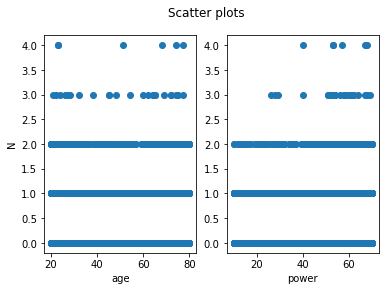

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

#Add a title
fig.suptitle('Scatter plots')

#Scatter plot 1
# Add scatterplot
ax1.scatter(df['age'],df['N'])
#Label the axes
ax1.set_xlabel('age')
ax1.set_ylabel('N')

#Scatter plot 2
# Add scatterplot
ax2.scatter(df['power'],df['N'])
#Label the axes
ax2.set_xlabel('power')

#Show the plot
plt.show()

With the scatter plots, we can observe the parabolic trend in age and the positive linear trend in power typically for high frequencies of claims.

### 2.3. Data split : Training and testing sets <a name="two-three"></a>

It is usually a good practice to separate the dataset into a training set and a test set because it allows to evaluate the model on unseen data, to dectect overfitting and to avoid it. The training set is used to train the model and the test set is used to test the predictive power of the model on unseen data and compare models between them.

Here we propose to split the initial dataset with the following proportion
* The training set will be composed of 80% of the initial database, and
* The test set will be composed of the remaining 20% of the initial database.

We first define the dataset of the features **X**. It contains the variables *age* and *power*. We also define the dataset of the response __y__ that contains the variable *N*.

In [17]:
# Features
X = df.drop(['N'], axis = 1)
print("Shape of features' set:", X.shape)

# Response (observed number of claims)
y = df['N']
print("Shape of response' set:", y.shape)

Shape of features' set: (20000, 2)
Shape of response' set: (20000,)


There are many ways to split the initial dataset into a training set and a testing set. We propose to use the `train_test_split()` function from `sklearn.model_selection` which allows us to quickly split the database.


This function takes as input the initial datasets X and y, the proportion that should be kept for the testing set (*test_size* argument) and a random state that allows to recover the same split over time (*random_state* argument).

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2020)

We then have
* **X_train** and **y_train**, the training sets of the features and the response, and
* **X_test** and **y_test**, the testing sets.

In [19]:
print("Shape of features' training set:", X_train.shape)
print("Shape of response' training set:", y_train.shape)
print("Shape of features' testing set:", X_test.shape)
print("Shape of response' testing set:", y_test.shape)

Shape of features' training set: (16000, 2)
Shape of response' training set: (16000,)
Shape of features' testing set: (4000, 2)
Shape of response' testing set: (4000,)


### 2.4. Define the model error <a name="two-four"></a>

In order to compare the performance of the different models on the test dataset, we define a loss function. We could for example simply consider the mean sum of squared (MSE)
$$ Error(\hat{y}) = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $$
where $y_i$ is the $i^{th}$ observation and $\hat{y}_i$ is the corresponding prediction, and $n$ is the number of observations.
We use the MSE when we assume that the response variable is normally distributed. 

Here we will perform the optimisation (and assess the quality of the predictions) by means of the poisson deviance because the response is the number of claims over one year which we assume is Poisson distributed. 

The deviance is a goodness-of-fit measure for a statistical model. It measures how much the log-likelihood of the fitted model deviates from the highest possible log-likelihood  (the one obtained by a so called saturated model which would perfectly predict all the observations). The likelihood measures how likely it is to have the observations we have in our datasets given the fitted model. The highest the likelihood the better. On the other hand, the smallest the deviance, the better. 

More precisely, the deviance is defined as the difference of likelihoods between the saturated model ($L_{SAT}$) and the fitted model ($L$): 

$$D=2(\ln(L_{SAT})-\ln(L))$$

The Poisson deviance is given by : 

$$ Error(\hat{y}) = 2 \sum_{i=1}^n \left( y_i \text{log} \left( \frac{y_i}{\hat{y}_i} \right) - \left( y_i - \hat{y}_i \right) \right) $$
where $y_i$ is the $i^{th}$ observed number of claims and $\hat{y}_i$ is the corresponding predicted number of claims.

In order to compute the prediction error we therefore define a function called `poisson_deviance`.

In [20]:
def poisson_deviance(y, y_pred):
    """The deviance function is evaluated for the Poisson distribution.
    Args :
        y: Target values
        y_pred : Estimated target values
    Returns :
        Poisson loss function
    """
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    nlogn = np.empty(y.size)
    dev = np.empty(y.size)
    
    for i in range(y.size):
        if y[i] == 0:
            nlogn[i] = 0
        else:
            nlogn[i] = y[i] * np.log(y[i] / y_pred[i])
            
        dev[i] = 2 * (nlogn[i] - (y[i] - y_pred[i]))
        
    return(dev.sum())

In order to compare the deviance on the training and testing sets we must have a mesure which does not depend on the size of the data set. We therefore also define a `mean_poisson_deviance`, which is the Poisson deviance divided by the number of observation.

In [21]:
def mean_poisson_deviance(y, y_pred):
    """Computes the mean of the Poisson deviance.
    Args :
        y: Target values
        y_pred: Estimated target values
    Returns:
        Mean Poisson deviance loss
    """
    return(poisson_deviance(y, y_pred)/y.size)

### 2.5. Computation of the flat model <a name="two-five"></a>

Before training different models on the *X_train* and *y_train* sets, we build a model using only the average claims frequency, not taking into account any of the 2 explanatory variables at disposal (the age of the policyholder and the power of the car). This model is called the flat model.

The global claims frequency of a portfolio ($\lambda$) is equal to the total number of claims divided by the total risk exposure of the portfolio. Here, the total risk exposure of the portfolio is the total number of observations in the dataset.

Here, we assume that all policyholders were in the portfolio the whole year so that the total risk exposure is equal to the number of policyholders in the portfolio. In practice the risk exposure must be assessed precisely in order to not over- or underestimate the claims frequency.

In [22]:
global_lambda = y_train.sum() / y_train.size
print("Global claim frequency:", global_lambda)

Global claim frequency: 0.114875


We can then assess if this global average claims frequency is a good predictor for the claims frequency on our test set. We therefore compute the prediction error using the loss function `mean_poisson_deviance` defined before.

In [23]:
# Prediction
y_pred_train = np.repeat(global_lambda, y_train.size)
y_pred_test = np.repeat(global_lambda, y_test.size)

# Metrics
print("Mean Poisson deviance on training set:", mean_poisson_deviance(y_train, y_pred_train))
print("Mean Poisson deviance on testing set:", mean_poisson_deviance(y_test, y_pred_test))

Mean Poisson deviance on training set: 0.5387770205449267
Mean Poisson deviance on testing set: 0.5543133401831292


We get 0.5388 on the training set and 0.5543 and the testing set.

| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |

## Chapter 3 - Regression trees <a name="three"></a>

Decisions trees are machine learning algorithms making predictions by sequentially splitting the covariate space into smaller segments, each segment receiving a different prediction. This process of spliting can be represented by a tree. 

The process of splitting is driven by the minimization of a loss function on a training test.

The difference between a classification and a regression tree is that a classification tree aims at predicting a category (discrete response variable with a finite number of non ordonated possible values, each possible value being a class) while a regression trees aims at predicting a continuous response variable or a discrete variable with infinite ordonated possible values)  

The loss functions and the predictions assigned to each segment depend on whether the tree is a classification or a regression tree : 

- classification tree : 
    - prediction in a node = most frequent class
    - loss function/impurity measure = Gini index, entropy index, missclassification error

- regression tree : 
    - prediction in a node = (weighted) mean of the target in the node, 50% quantile of the target in the node
    - loss function/impurity measure : MSE (mean squared error), deviance, MAE (mean absolute error)
    
    
|Tree type     |Target variable                   | Loss function              | Prediction           |
|--------------|----------------------------------|----------------------------|----------------------|
|Classification|Discrete & finite & no order                 |Gini,missclassification,... |Most frequent class   |
|Regression    |Continuous / Discrete not finite & order  |MSE, deviance,...	       |(Weighted) mean,...   | 

In this chapter, we propose to build a decision tree on our simulated data in order to model the frequency. Because our response variable (the claims frequency) is discrete variable with infinite ordonated possible values, we will consider a regression tree.

In order to build a regression tree, we will use the library `sklearn` and especially the module `tree` within that library. The function has already been imported in the beginning of the notebook. More information can be found by using the command `help(tree)`.

### 3.1. Training <a name="three-one"></a>

We first have to define the model. In order to do so, we make use of the `DecisionTreeRegressor` function from the `tree` module of `sklearn`.

This function takes as inputs, among others :

    criterion : The function to measure the quality of a split and to optimize the tree (here, we use the poisson deviance)
    min_samples_leaf : The minimum number of samples required to be at a leaf node (here the number is 6000)
    random_state : The random state controls the randomness of the estimator (here the random state is 2020)

In [24]:
reg_tree = tree.DecisionTreeRegressor(criterion = 'poisson', min_samples_leaf = 6000, random_state = 2020)

Let's now train the model on our training set by applying the `fit()` method on the class tree.

In [25]:
# Starting time
start = time.time()

# Training
reg_tree.fit(X_train, y_train)

# Elapsed time
end = time.time()
print("Seconds elapsed:", end - start)

Seconds elapsed: 0.0029993057250976562


Let's visualize what it looks like.

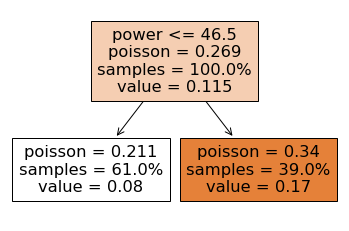

In [26]:
fig = plt.figure()
_=tree.plot_tree(reg_tree, 
                 feature_names=X_train.columns,  
                 filled=True,
                 proportion=True)
plt.show()

The first node contains the full training set. The final left node contains all the data for which the splitting condition is respected (hence it contains all the data with power <= 46.5). The final right node contains all the data which does not repect the splitting condition (hence all the data with power > 46.5). 

Each node represents a particular segment of the dataset. This segment is defined by the successive splitting rules made by the tree to reach that particular node. The final nodes (called leaves) correspond to the final segmentation of the tree and contain the final predictions of the tree. Here, the tree will assign a predicted claim frequency of 0.08 if the power is <= 46.5 and assign a predicted claim frequency of 0.17 otherwise (see the value argument in each final box). 

In each node you will also find the mean poisson deviance (poisson argument) and the proportion of the dataset in the node (samples argument).




Once the regression tree is trained, we can predict the response variable based on the training and test sets. We then calculate the mean Poisson deviance between the predicted and observed response values for the training and test sets by applying the method `predict()`.

In [27]:
# Prediction
y_pred_train = reg_tree.predict(X_train)
y_pred_test = reg_tree.predict(X_test)

# Metrics
print("Mean Poisson deviance on training set:", mean_poisson_deviance(y_train, y_pred_train))
print("Mean Poisson deviance on testing set:", mean_poisson_deviance(y_test, y_pred_test))

Mean Poisson deviance on training set: 0.5222939851534727
Mean Poisson deviance on testing set: 0.5416312495389723


We get 0.5223 on the training set and 0.5416 on the testing set, compared to 0.5388 and 0.5543 with the flat model, respectively.

| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |
| Reg Tree |  0.5223 | 0.5416 |

### 3.2. Cross-validation <a name="three-two"></a>

Overfitting occurs when a statistical model fits too much the data used for its training. It means that instead of capturing only the true structure between the features and the response variables it also captures noise. A model which overfits will perform very well on the training data but will not generalize well on new data (as by definition the noise will be totally different on new data)

On the previous section, we have defined two different kinds of errors :
- The training error is the error calculated by applying the model to the training data set used in its calibration,
- The test error is the average error that results from using the model to predict the response on new observations that were not used for calibrating the model. 

The idea is to have a model which is complex enough to capture all the relevant structure between the features and the response variables but not too complex to avoid capturing noise. A model too simple will underfit while a model too complex will overfit.

In order to estimate the optimal complexity parameter (= leading to the best performance on new data) a solution is to split the the full dataset into a training and validation set. The model is then fitted many times on the training set with different complexity parameters and the performance is assessed on the validation set. The best complexity is then the one minimizing the prediction error on the validation set.

However, this technique could lead to different results depending on how the split is made between training and validation set.

A more robust technique to estimate the generalization error of a model is the crossvalidation techique (which basically builds many different validation sets) : 

The idea of the method is to randomly divide the training data set into K equal-sized parts. We leave out part 𝑘, fit the model to the other 𝐾−1 parts (combined), and then obtain predictions for the left-out $𝑘^{th}$ part. This is done in turn for each part $𝑘 = 1,2,\dots,K$, and then the results are combined.

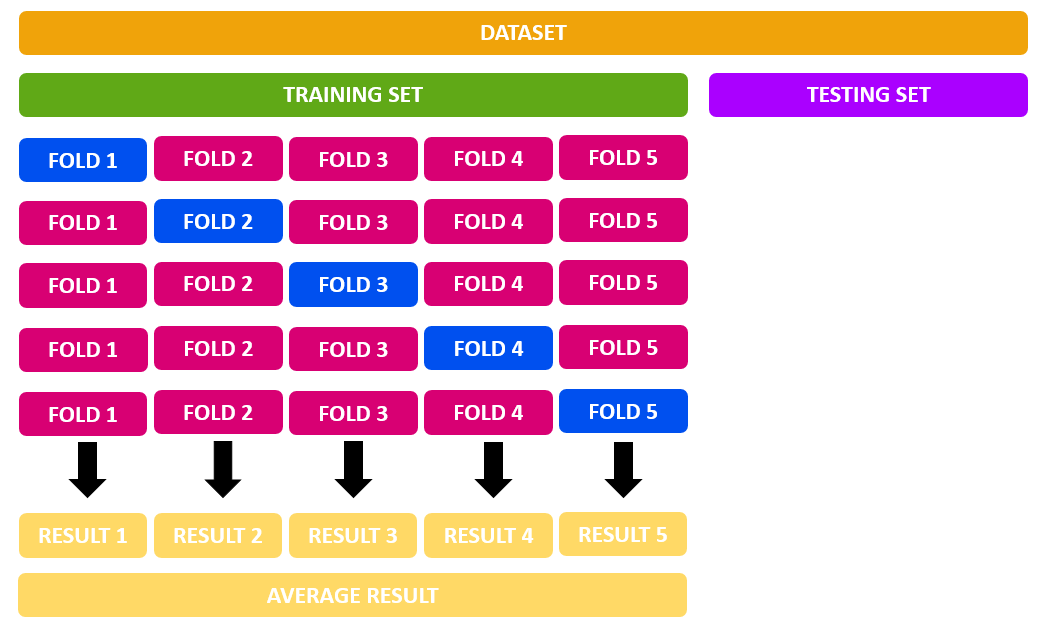

In [28]:
Image("www/cv.png")

### 3.2.1 Simple example<a name="three-two-one"></a>

The `KFold` class from `sklearn.model_selection` allows us to perform k-fold cross-validation quite easily. 

K-fold cross-validation :
1. Shuffle the dataset randomly
2. Split the dataset into K parts. 
3. For each part:
   - Set the part as the test dataset
   - Set the remaining parts as the training dataset
   - Fit the model on this training dataset and evaluate it on the test set
4. Compute the performance of the model as its mean performance over the K parts

Let's initiate the `KFold` object by shuffling the data beforehand and defining the number of splits at five.

In [29]:
num_k_fold = 5
kf = KFold(shuffle = True, n_splits = num_k_fold, random_state = 2020)

We use the `split()` method on a random dataset X to understand how the split works on the dataset indexes. We print the train and test indexes used on each fold.

In [30]:
import random
random.seed(2020)
X=random.sample(range(1, 100), 10)

k=1

for train_index, test_index in kf.split(X):
    print('rows contained in training set ',k,' : ', train_index)
    print('rows contained in testing set ',k,' : ', test_index)
    k = k+1

rows contained in training set  1  :  [0 1 3 5 6 7 8 9]
rows contained in testing set  1  :  [2 4]
rows contained in training set  2  :  [0 2 3 4 5 6 7 8]
rows contained in testing set  2  :  [1 9]
rows contained in training set  3  :  [0 1 2 3 4 6 8 9]
rows contained in testing set  3  :  [5 7]
rows contained in training set  4  :  [0 1 2 4 5 7 8 9]
rows contained in testing set  4  :  [3 6]
rows contained in training set  5  :  [1 2 3 4 5 6 7 9]
rows contained in testing set  5  :  [0 8]


For each fold, we want to record the training and testing mean Poisson deviance. We record these measures in a Pandas data frame with 2 columns (*Mean Deviance (testing)* and *Mean Deviance (training)*) and 5 rows filled with zeros.

In [31]:
scores = pd.DataFrame(columns = ['Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold, 2)))

We loop over the fold number (we have 5 iterations as we perform a k-fold with k equal to 5). For each fold, we have a training and testing sets. We can then train a regression tree and compute the mean Poisson deviance.

In [32]:
# For log
i = 0

# Cross-validation
for sub_train_index, sub_test_index in kf.split(X_train):
    # Select training and testing subsets
    X_train_cv, y_train_cv = X_train.iloc[sub_train_index], y_train.iloc[sub_train_index] 
    X_test_cv, y_test_cv = X_train.iloc[sub_test_index], y_train.iloc[sub_test_index]     
    
    # Training 
    reg_tree = tree.DecisionTreeRegressor(criterion = 'poisson', min_samples_leaf = 200, random_state = 2020)
    reg_tree.fit(X_train_cv, y_train_cv)
    
    # Predictions on the train and test
    y_pred_train = reg_tree.predict(X_train_cv)
    y_pred_test = reg_tree.predict(X_test_cv)

    # Metrics
    scores.at[i, 'Mean Deviance (testing)'] = mean_poisson_deviance(y_test_cv, y_pred_test)
    scores.at[i, 'Mean Deviance (training)'] = mean_poisson_deviance(y_train_cv, y_pred_train)
    
    # Log
    i = i + 1
    print('Fold number', i, 'completed...')

Fold number 1 completed...
Fold number 2 completed...
Fold number 3 completed...
Fold number 4 completed...
Fold number 5 completed...


Let's take a look at the results.

In [33]:
scores

,Mean Deviance (testing),Mean Deviance (training)
0,0.521576,0.494782
1,0.562512,0.483716
2,0.507634,0.498471
3,0.505073,0.498975
4,0.491178,0.501993


In [34]:
scores.mean()

Mean Deviance (testing)     0.517595
Mean Deviance (training)    0.495588
dtype: float64

The average mean Poisson deviance on the training set is 49.6% and 51.7% on the testing set.

### 3.2.2 Samples per leaf <a name="three-two-two"></a>

We choose the optimal decision tree parameters thanks of the cross-validation error. The strategy is to use choose the smallest tree whose cross-validation error is inside the region around one standard deviation of the minimum error.

Let's use K-fold cross-validation in order to determine a relevant minimum number of samples per leaf. We perform the K-fold cross validation for the following values for the minimum number of samples per leaf: [200, 400, ..., 2000].

__Runtime:__  Be carefull that K-fold cross-validation can take some time according to the complexity of the model, *i.e.* the minimum number of samples per leaf in each tree.

In [35]:
min_sample_per_leaf = np.arange(start = 200, stop = 2001, step = 200)
min_sample_per_leaf

array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800, 2000])

Let's consider a k-fold cross-validation with $K = 5$.

In [36]:
num_k_fold = 5

We record the training and testing mean Poisson deviance in a data frame for the corresponding minimum number of samples per leaf. The number of rows is then equal to 5 x 8 = 40.

In [37]:
scores = pd.DataFrame(columns = ['Min samples per leaf', 'Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold * len(min_sample_per_leaf), 3)))

In [38]:
# Initiate k-fold object
kf = KFold(n_splits = num_k_fold, shuffle = True, random_state = 2020)

For each minimum number of samples per leaf in `min_sample_per_leaf`, we do the k-fold cross-validation. We will implement a double nested loop. The first loop `j` will be over the different numbers of minimum number of samples per leaf. For each minimum number of samples per leaf, `i` tracks the subfold used on K-fold cross-validation. `sub_train_index` and `sub_test_index` tracks the indexes used on K-fold cross-validation.

In [39]:
# Starting time
start_global = time.time()

# Loop over the number of minimum number of samples per leaf
for j in range(len(min_sample_per_leaf)):
    i = 0
        
    # Record starting time
    start = time.time()
    
    # k-fold cross-validation for the selected minimum number of samples per leaf
    for sub_train_index, sub_test_index in kf.split(X_train):
        # Select training and testing subsets
        X_train_cv, y_train_cv = X_train.iloc[sub_train_index], y_train.iloc[sub_train_index]
        X_test_cv, y_test_cv = X_train.iloc[sub_test_index], y_train.iloc[sub_test_index]
        
        # Training
        reg_tree = tree.DecisionTreeRegressor(criterion = 'poisson', min_samples_leaf = min_sample_per_leaf[j], random_state = 2020)
        reg_tree.fit(X_train_cv, y_train_cv)
        
        # Prediction
        y_pred_train = reg_tree.predict(X_train_cv)
        y_pred_test = reg_tree.predict(X_test_cv)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Min samples per leaf'] = min_sample_per_leaf[j]
        scores.at[index, 'Mean Deviance (testing)'] = mean_poisson_deviance(y_test_cv, y_pred_test)
        scores.at[index, 'Mean Deviance (training)'] = mean_poisson_deviance(y_train_cv, y_pred_train)
        i = i + 1
    
    # Elasped time for the k-fold step
    end = time.time()
    elapsed = end - start
    print('Step', j + 1, 'completed (', elapsed, 'sec)...')

# Global elapsed time
end_global = time.time()
elapsed = end_global - start_global
print('Total time:', elapsed, 'sec!')

Step 1 completed ( 0.24410629272460938 sec)...
Step 2 completed ( 0.2418527603149414 sec)...
Step 3 completed ( 0.24481558799743652 sec)...
Step 4 completed ( 0.25163698196411133 sec)...
Step 5 completed ( 0.25107669830322266 sec)...
Step 6 completed ( 0.22859430313110352 sec)...
Step 7 completed ( 0.23263168334960938 sec)...
Step 8 completed ( 0.2345883846282959 sec)...
Step 9 completed ( 0.23695945739746094 sec)...
Step 10 completed ( 0.22833681106567383 sec)...
Total time: 2.394598960876465 sec!


We group the results according to the minimum number of samples per leaf and compute the average errors.

In [40]:
gp = scores.groupby('Min samples per leaf')
means = gp.mean()

We plot the mean Poisson deviance (averaged over the different crossvalidation training and testing sets) in function of the minimum number of samples per leaf.

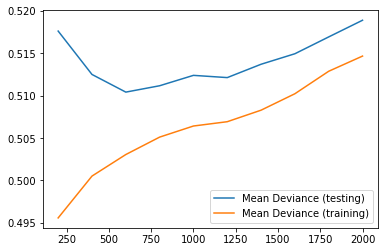

In [41]:
measures = ['Mean Deviance (testing)','Mean Deviance (training)']
plt.figure()
plt.plot(means[measures])
plt.legend(measures)
plt.show()

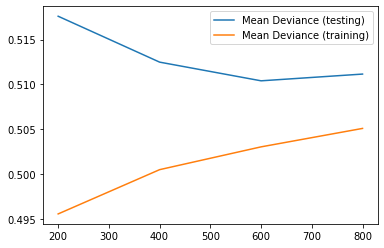

In [42]:
plt.figure()
plt.plot(means.loc[means.index <= 800,measures])
plt.legend(measures)
plt.show()

You should read this graph from right to left because a small number of observations per leaf means a greater complexity. 

As expected, the mean Poisson deviance decreases with the complexity of the model on the training set. However, for the testing set, the average of the mean Poisson deviance, after decreasing with the complexity of the model, seems to rise for higer complexity. This is an illustration of overfitting. 

The minimum testing error is reached at 600 which corresponds then to the optimal complexity.

### 3.3. Variable importance measure <a name="three-three"></a>

The importance of a variable measures how much the prediction of a model depends on the variable. It then also reflects how much the response variable depends on this variable. 

We first initiate our tree and then train it.

In [43]:
reg_tree = tree.DecisionTreeRegressor(criterion = 'poisson', min_samples_leaf = 600, random_state = 2020)

Let's train the model.

In [44]:
# Starting time
start = time.time()

# Training
reg_tree.fit(X_train, y_train)

# Elapsed time
end = time.time()
print("Seconds elapsed:", end - start)

Seconds elapsed: 0.007076263427734375


Let's visualize what it looks like.

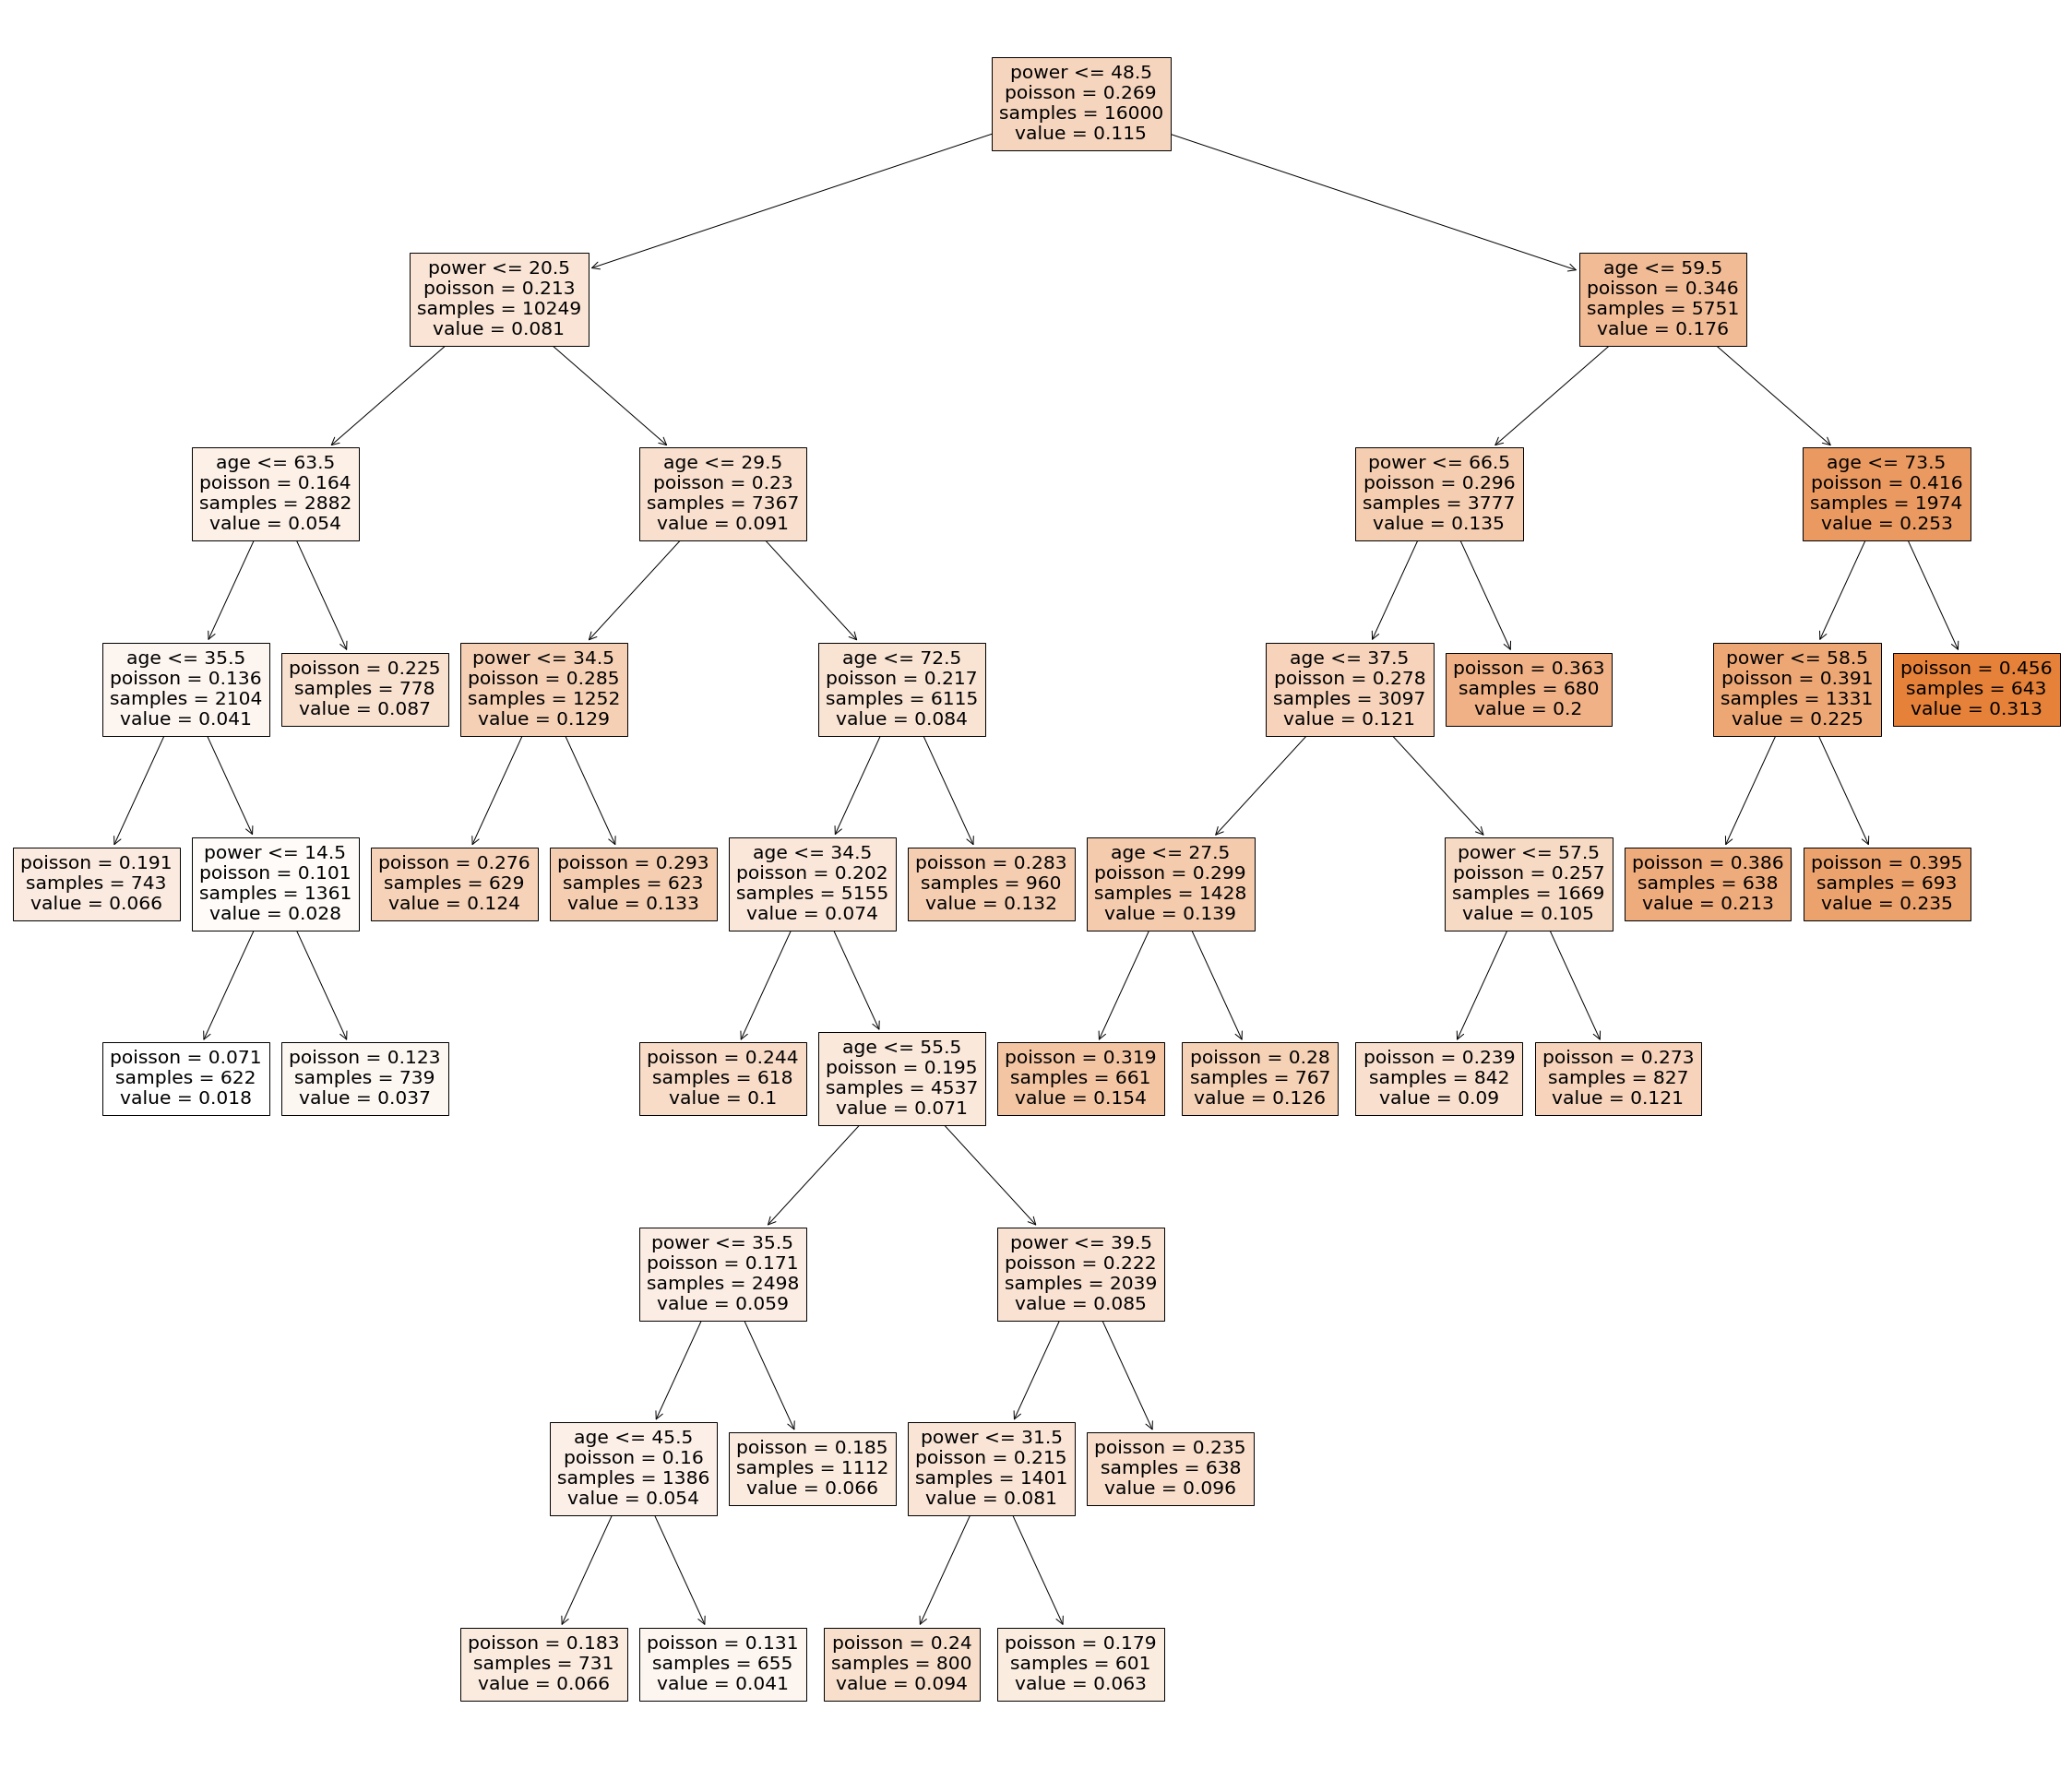

In [45]:
fig = plt.figure(figsize=(40,35))
_=tree.plot_tree(reg_tree, 
                 feature_names=X_train.columns,  
                 filled=True,
                 proportion=False)
plt.show()

We now compute the mean Poission deviance.

In [46]:
# Prediction
y_pred_train = reg_tree.predict(X_train)
y_pred_test = reg_tree.predict(X_test)

# Metrics
print("Mean Poisson deviance on training set:", mean_poisson_deviance(y_train, y_pred_train))
print("Mean Poisson deviance on testing set:", mean_poisson_deviance(y_test, y_pred_test))

Mean Poisson deviance on training set: 0.5025573871875233
Mean Poisson deviance on testing set: 0.5209743031190281




| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |
| Reg Tree |  0.5223 | 0.5416 |
| Tuned Reg Tree |  0.5026 |  0.5210 |

Given this model, let's consider the variable importance measures by applying the method `feature_importances_` on the regression tree.

The variable importance is determined by calculating the relative influence of each variable: whether that variable was selected to split on during the tree building process, and how much the fitting error (over all trees) improved (decreased) as a result.

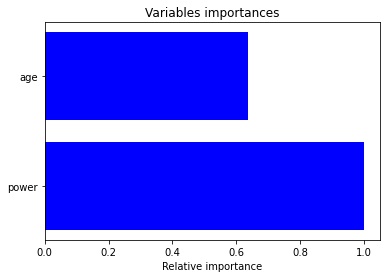

In [47]:
# Features' names
features = list(X_train)

# Importance measures
importances = reg_tree.feature_importances_

# We sort the features by highest importance
indices = np.flip(np.argsort(importances))

# Plot

#Add the title
plt.title('Variables importances')

#Add the bar plot
plt.barh(range(len(indices)), importances[indices] / importances[indices[0]], color = 'b', align = 'center')

#Label the x axe and set the y-axis tick values
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')

#Show the plot
plt.show()

In this model, the power feature is the most important one. The age feature has a relative importance of about 64% compared to the power.

In [48]:
# Relative importance of the second most important feature (the age)
importances[indices[1]] / importances[indices[0]]

0.6373386595160694

### 3.4. Partial dependence <a name="three-four"></a>

As it has been described in the first chapter, the dataset is constructed with a quadratic dependence with the variable age, a linear dependence with the power, and a nonlinear interaction between the two variables.

In this section, we study how the regression tree defined in the previous section captures these dependences.

The mathematical tool we consider is the *partial dependence*. Partial dependence plots show the marginal effect of a variable on the predicted outcome of a previously fitted model. It can thus show if the relationship between the target variable and the explanaroty variable is linear, monotonic or more complex.

* **Partial Dependence Plots**

The Partial Dependency Plots provide the estimation of the marginal response of a model. PDP’s present the marginal relation between the response variable of interest and a single explanatory variable from the model. In a more formal way, let us assume we have calibrated a model $𝑓(𝑋_1, \vec{X})$. The PDP at a given value $𝑥_1$ is given by :
$$ PDP(x_1) = \mathcal{𝐸}[𝑓(𝑥_1,\vec{X})]$$
The $PDP(x_1)$ is the mean prediction at $𝑥_1$ using marginal distribution of $\vec{x}$.

To create a PDP, we vary the value for one of the features and record the resulting predictions. We do this while holding the other features constant at their real values.

Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest. A flat PDP indicates that the feature is not important.

Partial dependence plots are easy to build and are thus a convenient way to display the results of the models fitted. For visualization's reasons, it is however difficult to build PDP with more than 3 variables. For instance, the following line of code plots the partial dependence between the age feature and the response.

We use `from_estimator` to create a `PartialDependenceDisplay`. For instance, the following line of code plots the partial dependence between the age feature and the response and between the power and the response.

<Figure size 5760x5040 with 0 Axes>

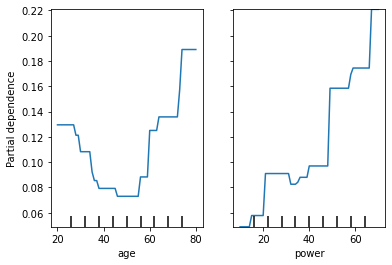

In [49]:
#Labels
labels=['age', 'power']

#PDP
plt.figure(figsize=(80,70))
PartialDependenceDisplay.from_estimator(reg_tree,X_train, labels)
plt.show()

We observe that the model captures a kind of quadratic interaction between the age and the frequency.

We observe that the model also captures a linear dependence between the power of the car and the frequency.

We can also look at the partial dependence of the frequency given the age and power.

<Figure size 5760x5040 with 0 Axes>

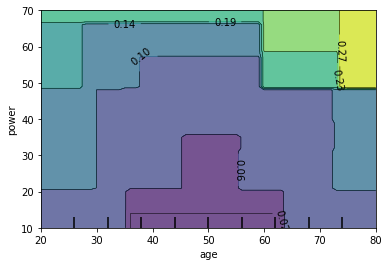

In [50]:
#Labels
labels=[('age', 'power')]

#PDP
plt.figure(figsize=(80,70))
pdp=PartialDependenceDisplay.from_estimator(reg_tree,X_train, labels)
plt.show()

It can be compared to the contour plot of the true relation between $\lambda$ and the features as presented in the first chapter.

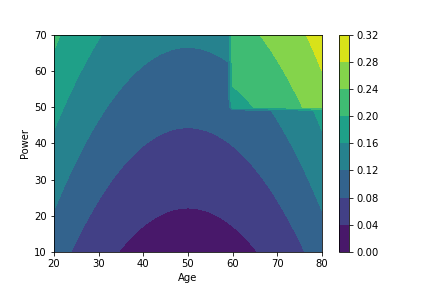

In [51]:
Image("www/freqs_contour.png")

Instead of looking at the contour plot, we can also compare the 3D plots. We first make the 3D plot of the partial dependence.

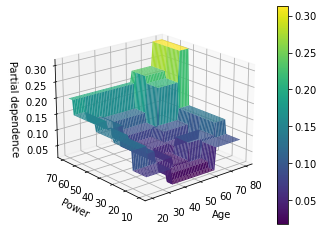

In [52]:
fig = plt.figure()
target_feature = (0, 1)
names = ["Age", "Power"]

pdp = partial_dependence(reg_tree, X_train, target_feature)

pdp_av=pdp['average']
axes = pdp['values']


#create a rectangular grid out of two given one-dimensional arrays
XX, YY = np.meshgrid(axes[0], axes[1])

Z = pdp_av.reshape(list(map(np.size, axes))).T #transpose of this matrix

ax =plt.subplot(projection="3d") #3D Axes


# Plot the surface
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.viridis)

#Label the axes
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_zlabel('Partial dependence')

#Add a colorbar
ax.view_init(elev=20, azim=230) #used to rotate the axes programmatically
plt.colorbar(surf)

#Show the plot
plt.show()

We can compare it with the one of the first chapter.

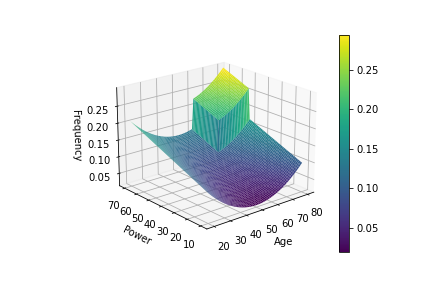

In [53]:
Image("www/freqs_3d.png")

## Chapter 4 - Random forests <a name="four"></a>

Let's now consider random forest models that operate as ensemble methods. Ensembles are methods that combine multiple machine learning models to create more powerfull models.

* **Bagging**

Usually multiple training sets are not at disposal and that is the reason why the bagging procedure has been developed. This procedure operates as follows:
- Randomly take m (m<n) observations from the total single training dataset containing n observations, and do this repeatedly to create a large number (B) of sub-datasets. 
- Calibrate the model on each of the generated sub-datasets to obtain a large number of different predictions
- Average all the predictions to obtain the final one


* **Random forest**

Random forests provide an improvement over bagging thanks to an additional step that decorrelates the trees. 

We decorrelate the trees by following the following procedure :
when building these decision trees, each time a split in a tree is considered, a random selection of k predictors is chosen as split candidates from the full set of 𝑝 predictors. The split can only use one of those k predictors. 

This reduces the variance when we average the trees.

So a random forest is essentially a collection of decision trees, where each tree is slightly different from the others. Random forests builds a large collection of de-correlated trees with bootstrapping, and then aggregates the decisions of individual trees.

In order to build a random forest, we will also use the library `sklearn` and especially the module `ensemble` within that library. The function has already been imported in the beginning of the notebook. More information can be found by using the command `help(ensemble)`.

### 4.1. Training <a name="four-one"></a>

As it was the case for the regression tree, we first define the model. We make use of the `RandomForestRegressor` function from the `ensemble` module of `sklearn`.

We initiate the random forest regressor with the following parameters :

    criterion : The function to measure the quality of a split and to optimize the tree (here, we use the poisson deviance)
    n_estimators : The number of trees in the forest (20 trees in the forest)
    min_samples_leaf : The minimum number of samples required to be at a leaf node (here, this number is 600)
    max_features : The number of features to consider when looking for the best split (If None,   then max_features=n_features) 
    random_state : The random state (here the random state is 2020)

In [54]:
reg_rf = ensemble.RandomForestRegressor(criterion = "poisson", n_estimators = 20,
                                    min_samples_leaf = 600, random_state = 2020)

Let's train the model.

In [55]:
# Starting time
start = time.time()

# Training
reg_rf.fit(X_train, y_train)

# Elapsed time
end = time.time()
print("Seconds elapsed:", end - start)

Seconds elapsed: 0.12872004508972168


Let's take a look at the mean Poission deviance.

In [56]:
# Prediction
y_pred_train = reg_rf.predict(X_train)
y_pred_test = reg_rf.predict(X_test)

# Metrics
print("Mean Poisson deviance on training set:", mean_poisson_deviance(y_train, y_pred_train))
print("Mean Poisson deviance on testing set:", mean_poisson_deviance(y_test, y_pred_test))

Mean Poisson deviance on training set: 0.503308655837555
Mean Poisson deviance on testing set: 0.5202341732481138




| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |
| Reg Tree |  0.5223 | 0.5416 |
| Tuned Reg Tree |  0.5026 |  0.5210 |
| RF| 0.5033 | 0.5202 |

### 4.2. Cross-validation <a name="four-two"></a>

Let's use k-fold cross-validation in order to determine a relevant minimum number of samples per leaf.

We consider 50, 100, up to 800 as the minimum number of samples per leaf.

__Runtime:__  Be carefull that k-fold cross-validation can take some time according to the complexity of the model, *i.e.* the minimum number of samples per leaf in each tree.

In [57]:
min_sample_per_leaf = np.arange(start = 50, stop = 801, step = 50)
min_sample_per_leaf


array([ 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650,
       700, 750, 800])

We do k-fold with $k = 5$.

In [58]:
num_k_fold = 5

We initiate the K-fold

In [59]:
# Initiate k-fold object
kf = KFold(n_splits = num_k_fold, shuffle = True, random_state = 2020)

We record the training and testing mean Poisson deviance in a data frame.

In [60]:
scores = pd.DataFrame(columns = ['Min samples per leaf', 'Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold * len(min_sample_per_leaf), 3)))

For each minimum number of samples per leaf in `min_sample_per_leaf`, do the k-fold cross-validation.

In [61]:
# Starting time
start_global = time.time()

# Loop over the number of minimum number of samples per leaf
for j in range(len(min_sample_per_leaf)):
    i = 0
    
    # Record starting time
    start = time.time()
    
    # k-fold cross-validation for the selected minimum number of samples per leaf
    for sub_train_index, sub_test_index in kf.split(X_train):
        # Select training and testing subsets
        X_train_cv, y_train_cv = X_train.iloc[sub_train_index], y_train.iloc[sub_train_index]
        X_test_cv, y_test_cv = X_train.iloc[sub_test_index], y_train.iloc[sub_test_index]
        
        # Training
        reg_rf = ensemble.RandomForestRegressor(criterion = "poisson", n_estimators = 20,
                                            min_samples_leaf = min_sample_per_leaf[j], random_state = 2020)
        
        reg_rf.fit(X_train_cv, y_train_cv)
        
        # Prediction
        y_pred_train = reg_rf.predict(X_train_cv)
        y_pred_test = reg_rf.predict(X_test_cv)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Min samples per leaf'] = min_sample_per_leaf[j]
        scores.at[index, 'Mean Deviance (testing)'] = mean_poisson_deviance(y_test_cv, y_pred_test)
        scores.at[index, 'Mean Deviance (training)'] = mean_poisson_deviance(y_train_cv, y_pred_train)
        i = i + 1
    
    # Elasped time for the k-fold step
    end = time.time()
    elapsed = end - start
    print('Step', j + 1, 'completed (', elapsed, 'sec)...')

# Global elapsed time
end_global = time.time()
elapsed = end_global - start_global
print('Total time:', elapsed, 'sec!')

Step 1 completed ( 1.2586674690246582 sec)...
Step 2 completed ( 1.1748247146606445 sec)...
Step 3 completed ( 1.0757880210876465 sec)...
Step 4 completed ( 1.0909016132354736 sec)...
Step 5 completed ( 1.008953332901001 sec)...
Step 6 completed ( 0.9695103168487549 sec)...
Step 7 completed ( 0.8777227401733398 sec)...
Step 8 completed ( 0.8768553733825684 sec)...
Step 9 completed ( 0.8068141937255859 sec)...
Step 10 completed ( 0.9363210201263428 sec)...
Step 11 completed ( 0.8060624599456787 sec)...
Step 12 completed ( 0.9048075675964355 sec)...
Step 13 completed ( 0.9222376346588135 sec)...
Step 14 completed ( 0.8217241764068604 sec)...
Step 15 completed ( 0.8603570461273193 sec)...
Step 16 completed ( 0.7800698280334473 sec)...
Total time: 15.173616170883179 sec!


We group the results according to the minimum number of samples per leaf and compute the average errors.

In [62]:
gp = scores.groupby('Min samples per leaf')
means = gp.mean()

We plot the mean Poisson deviance over the different crossvalidation training and testing sets in function of  the minimum number of samples per leaf.

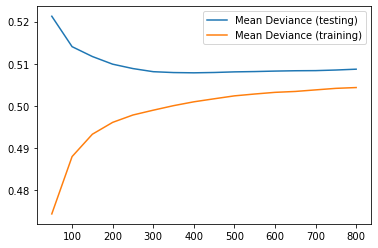

In [63]:
measures = ['Mean Deviance (testing)','Mean Deviance (training)']
plt.figure()
plt.plot(means[measures])
plt.legend(measures)
plt.show()

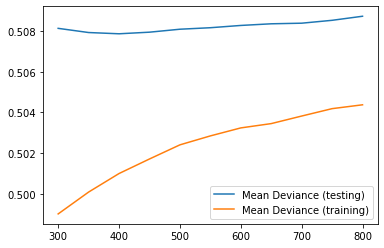

In [64]:
plt.figure()
plt.plot(means.loc[means.index >= 300,measures])
plt.legend(measures)
plt.show()

The mean Poisson deviance decreases on the testing set with the number of observations per leaf up to a minimum around 400. We keep this value as the best value. Let us also note that the random forest allows to grow deeper trees than a simple regression tree without overfitting. This is because all those deeper trees are averaged. This mean prediction is more generalizable than the prediction of a single deep tree.

### 4.3. Variable importance measure <a name="four-three"></a>

We once again take a look at the variable importance measure for our best model.

We first initiate our best random forest.

In [65]:
reg_rf = ensemble.RandomForestRegressor(criterion = "poisson", n_estimators = 20,
                                    min_samples_leaf = 400, random_state = 2020)

We train the model.

In [66]:
# Starting time
start = time.time()

# Training
reg_rf.fit(X_train, y_train)

# Elapsed time
end = time.time()
print("Seconds elapsed:", end - start)

Seconds elapsed: 0.11243200302124023


We now compute the mean Poission deviance.

In [67]:
# Prediction
y_pred_train = reg_rf.predict(X_train)
y_pred_test = reg_rf.predict(X_test)

# Metrics
print("Mean Poisson deviance on training set:", mean_poisson_deviance(y_train, y_pred_train))
print("Mean Poisson deviance on testing set:", mean_poisson_deviance(y_test, y_pred_test))

Mean Poisson deviance on training set: 0.5008205880856668
Mean Poisson deviance on testing set: 0.5200030601508153



| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |
| Reg Tree |  0.5223 | 0.5416 |
| Tuned Reg Tree |  0.5026 |  0.5210 |
| RF| 0.5033 | 0.5202 |
| Tuned RF| 0.5008 | 0.5200 |

Let's take a look at the variable importance measures.

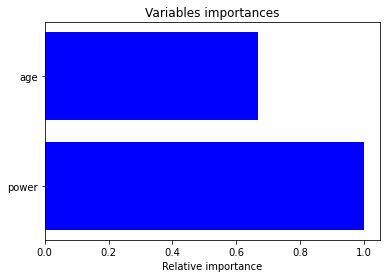

In [68]:
# Features' names
features = list(X_train)

# Importance measures
importances = reg_rf.feature_importances_

# We sort the features by highest importance
indices = np.flip(np.argsort(importances))

# Plot

#Add the title
plt.title('Variables importances')

#Add the bar plot
plt.barh(range(len(indices)), importances[indices] / importances[indices[0]], color = 'b', align = 'center')

#Label the x axe and set the y-axis tick values
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')

#Show the plot
plt.show()

In this model, the power feature is the most important one as it was the case with the regression tree. The age feature has a relative importance of about 67% compared to the power, which is similar to the regression tree.

In [69]:
# Relative importance of the second most important feature (the age)
importances[indices[1]] / importances[indices[0]]

0.6677250982459493

### 4.4. Partial dependence <a name="four-four"></a>

As we did for the regression tree, let's take a look at the partial dependence.

We use `from_estimator` to create a `PartialDependenceDisplay`. For instance, the following line of code plots the partial dependence between the age feature and the response and between the power and the response.

<Figure size 5760x5040 with 0 Axes>

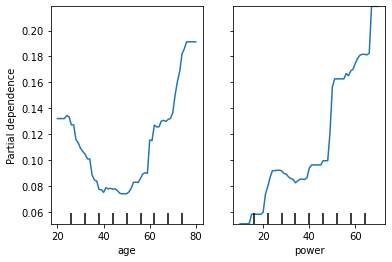

In [70]:
#Labels
labels=['age', 'power']

#PDP
plt.figure(figsize=(80,70))
PartialDependenceDisplay.from_estimator(reg_rf,X_train, labels)
plt.show()

We observe that the model captures a kind of quadratic interaction between the age and the frequency.

We observe that the model also captures a linear dependence between the power of the car and the frequency.

We can also look at the partial dependence of the frequency given the age and power.

<Figure size 5760x5040 with 0 Axes>

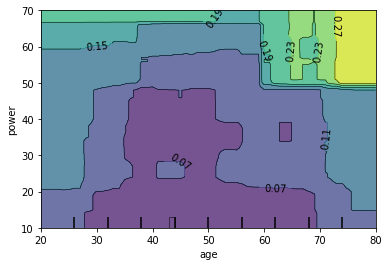

In [71]:
#Labels
labels=[('age', 'power')]

#PDP
plt.figure(figsize=(80,70))
pdp=PartialDependenceDisplay.from_estimator(reg_rf,X_train, labels)
plt.show()

It can be compared to the contour plot of the true relation between $\lambda$ and the features as presented in the first chapter.

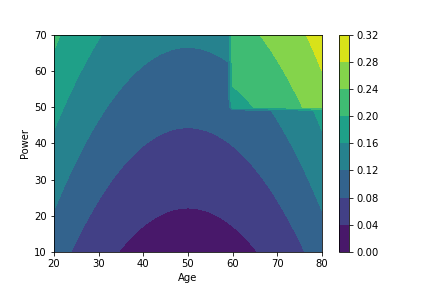

In [72]:
Image("www/freqs_contour.png")

Instead of looking at the contour plot, we can also compare the 3D plots. We first make the 3D plot of the partial dependence.

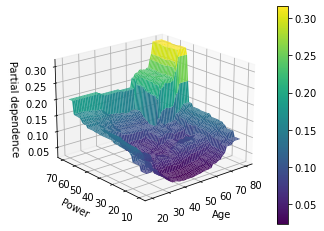

In [73]:
fig = plt.figure()

target_feature = (0, 1)
names = ["Age", "Power"]

pdp = partial_dependence(reg_rf, X_train, target_feature)

pdp_av=pdp['average']
axes = pdp['values']

#create a rectangular grid out of two given one-dimensional arrays
XX, YY = np.meshgrid(axes[0], axes[1])

Z = pdp_av.reshape(list(map(np.size, axes))).T #transpose of this matrix

ax =plt.subplot(projection="3d") #3D Axes

# Plot the surface
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.viridis)

#Label the axes
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')

#Add a colorbar
ax.view_init(elev=20, azim=230) #used to rotate the axes programmatically
plt.colorbar(surf)

#Show the plot
plt.show()

We can compare it with the one of the first chapter.

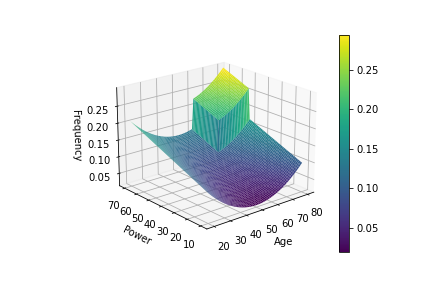

In [74]:
Image("www/freqs_3d.png")

If we compare the 3D partial dependence plot with the one obtained through the regression tree, we get less jumps with the random forest due to the bagging of many regression trees. We then better capture the interaction between the features and the response.

## Chapter 5 - Gradient boosting <a name="five"></a>

In this chapter, we consider the gradient boosting technique in order to model the frequency of claims per policy.

In order to build a gradient boosting model, we will use the library `xgboost` which allows to specify a poisson distribution on the response variable

### 5.1. Training <a name="five-one"></a>

As it was the case for both the regression tree and the random forest, we first define the model. We make use of the `XGBRegressor` function from `sklearn`.

We initiate the gradient boosting regressor.

* We consider the Poisson deviance both for the splitting of a node in a given tree of the boosting and for the global boosting algorithm
* The number of trees is set to 40.
* The maximal depth of a tree is set to 3.
* The learning rate is set to 0.1.
* Let the seed used by the random number generator be equal to 2020.

We train the model on the training dataset.

In [75]:
gbm = xgb.XGBRegressor(n_estimators = 40,
                                 objective='count:poisson',
                                 max_depth = 3,
                                 learning_rate = 0.1,
                                random_state = 2020)

gbm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0.699999988, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=0, num_parallel_tree=1,
             objective='count:poisson', predictor='auto', random_state=2020,
             reg_alpha=0, ...)

We can then compute the predictions on both the train and test sets : 

In [76]:
# Prediction
y_pred_train = gbm.predict(X_train)
y_pred_test = gbm.predict(X_test)

# Metrics
print("Mean Poisson deviance on training set:", mean_poisson_deviance(y_train, y_pred_train))
print("Mean Poisson deviance on testing set:", mean_poisson_deviance(y_test, y_pred_test))

Mean Poisson deviance on training set: 0.5290035180169609
Mean Poisson deviance on testing set: 0.5425336648881283


| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |
| Reg Tree |  0.5223 | 0.5416 |
| Tuned Reg Tree |  0.5026 |  0.5210 |
| RF| 0.5033 | 0.5202 |
| Tuned RF| 0.5008 | 0.5200 |
| GBM| 0.5290 | 0.5425 |

This non tuned GBM performs the same as the non tuned regression tree

### 5.2. Cross-validation <a name="five-two"></a>

Let's use k-fold cross-validation in order to determine a relevant number of trees.

We want to test the model with 10, 20 up to 200 trees.

__Runtime:__ Be carefull that k-fold cross-validation can take some time according to the complexity of the model, *i.e.* the number of trees in the forest.

In [77]:
num_trees = np.arange(10, 210, 10)
num_trees

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])

We do k-fold with $k = 5$.

In [78]:
num_k_fold = 5

In [79]:
kf = KFold(n_splits = num_k_fold, shuffle = True, random_state = 2020)

We record the training and testing mean Poisson deviance in a data frame.

In [80]:
scores = pd.DataFrame(columns = ['Number of trees', 'Mean Deviance (testing)', 'Mean Deviance (training)'],
                      data = np.zeros((num_k_fold * len(num_trees), 3)))
scores.head()

,Number of trees,Mean Deviance (testing),Mean Deviance (training)
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


For each number of trees in `num_trees`, we do k-fold cross-validation.

In [81]:
# Starting time
start_global = time.time()

# Loop over the number of minimum number of samples per leaf
for j in range(len(num_trees)):
    i = 0
    

    
    
    # Record starting time
    start = time.time()
    
    # k-fold cross-validation for the selected minimum number of samples per leaf
    for train, test in kf.split(X_train):
        # Select training and testing subsets
        X_train_cv, y_train_cv = X_train.iloc[train], y_train.iloc[train]
        X_test_cv, y_test_cv = X_train.iloc[test], y_train.iloc[test]
        
        # Training
        
        gbm = xgb.XGBRegressor(n_estimators = num_trees[j],
                                 objective='count:poisson',
                                 max_depth = 3,
                                 learning_rate = 0.1,
                                random_state = 2020)
        
        gbm.fit(X_train_cv, y_train_cv)
        
        # Prediction
        y_pred_train = gbm.predict(X_train_cv)
        y_pred_test = gbm.predict(X_test_cv)

        # Metrics
        index = j * num_k_fold + i
        scores.at[index, 'Number of trees'] = num_trees[j]
        scores.at[index, 'Mean Deviance (testing)'] = mean_poisson_deviance(y_test_cv, y_pred_test)
        scores.at[index, 'Mean Deviance (training)'] = mean_poisson_deviance(y_train_cv, y_pred_train)
        i = i + 1
    
    # Elasped time for the k-fold step
    end = time.time()
    elapsed = end - start
    print('Step', j + 1, 'completed (', elapsed, 'sec)...')

# Global elapsed time
end_global = time.time()
elapsed = end_global - start_global
print('Total time:', elapsed, 'sec!')

Step 1 completed ( 0.5738997459411621 sec)...
Step 2 completed ( 0.595815896987915 sec)...
Step 3 completed ( 0.6383821964263916 sec)...
Step 4 completed ( 0.7005953788757324 sec)...
Step 5 completed ( 0.7479903697967529 sec)...
Step 6 completed ( 0.7936408519744873 sec)...
Step 7 completed ( 0.8358988761901855 sec)...
Step 8 completed ( 0.9014818668365479 sec)...
Step 9 completed ( 0.9423754215240479 sec)...
Step 10 completed ( 1.0152125358581543 sec)...
Step 11 completed ( 1.0462729930877686 sec)...
Step 12 completed ( 1.0874016284942627 sec)...
Step 13 completed ( 1.169205904006958 sec)...
Step 14 completed ( 1.196716070175171 sec)...
Step 15 completed ( 1.2800850868225098 sec)...
Step 16 completed ( 1.3012902736663818 sec)...
Step 17 completed ( 1.457050085067749 sec)...
Step 18 completed ( 1.4443602561950684 sec)...
Step 19 completed ( 1.426525592803955 sec)...
Step 20 completed ( 1.4845359325408936 sec)...
Total time: 20.642746686935425 sec!


We group the results according to the number of trees and compute the average errors.

In [82]:
gp = scores.groupby('Number of trees')
means = gp.mean()

We plot the mean Poisson deviance over the different crossvalidation training and testing sets in function of the number of trees.

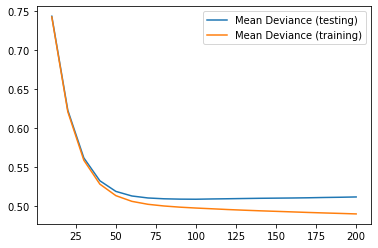

In [83]:
measures = ['Mean Deviance (testing)','Mean Deviance (training)']
plt.figure()
plt.plot(means[measures])
plt.legend(measures)
plt.show()

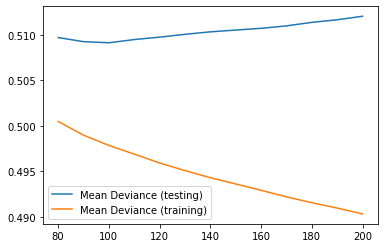

In [84]:
plt.figure()
plt.plot(means.loc[means.index >= 80,measures])
plt.legend(measures)
plt.show()

The mean Poisson deviance decreases on the testing set with the number of trees up to a minimum around 100. We keep this value as the best value.

### 5.3. Variable importance measure <a name="five-three"></a>

We once again compute the variable importance measure for our best model.

We first initiate our best gradient boosting model.

In [85]:
gbm = xgb.XGBRegressor(n_estimators = 100,
                                 objective='count:poisson',
                                 max_depth = 3,
                                 learning_rate = 0.1,
                                random_state = 2020)

We train the model.

In [86]:
# Starting time
start = time.time()

# Training
gbm.fit(X_train, y_train)

# Elapsed time
end = time.time()
print("Seconds elapsed:", end - start)

Seconds elapsed: 0.1222543716430664


We compute the mean Poission deviance.

In [87]:
# Prediction
y_pred_train = gbm.predict(X_train)
y_pred_test = gbm.predict(X_test)

# Metrics
print("Mean Poisson deviance on training set:", mean_poisson_deviance(y_train, y_pred_train))
print("Mean Poisson deviance on testing set:", mean_poisson_deviance(y_test, y_pred_test))

Mean Poisson deviance on training set: 0.4995889898543003
Mean Poisson deviance on testing set: 0.5195124030436923


We get 0.5195 on the testing set. Increasing the number of trees allowed to improve the predictive power of the GBM.

| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |
| Reg Tree |  0.5223 | 0.5416 |
| Tuned Reg Tree |  0.5026 |  0.5210 |
| RF| 0.5033 | 0.5202 |
| Tuned RF| 0.5008 | 0.5200 |
| GBM| 0.5290 | 0.5425 |
| tuned GBM| 0.4996 | 0.5195 |

Let's take a look at the variable importance measures.

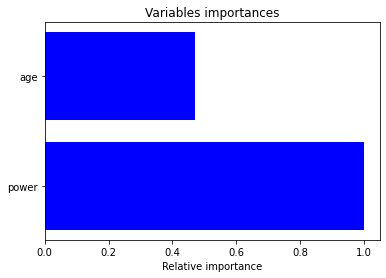

In [88]:
# Features' names
features = list(X_train)

# Importance measures
importances = gbm.feature_importances_

# The 10 first features with highest importance
indices = np.flip(np.argsort(importances))[0:10]

# Plot
plt.title('Variables importances')
plt.barh(range(len(indices)), importances[indices] / importances[indices[0]], color = 'b', align = 'center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative importance')
plt.show()

Once again, the power feature is the most important one as it was the case with the previous models. The age feature has a relative importance of about 47% compared to the power, which is similar to the other models.

In [89]:
# Relative importance of the second most important feature (the age)
importances[indices[1]] / importances[indices[0]]

0.47253427

### 5.4. Partial dependence <a name="five-four"></a>

As we did for the regression tree and the random forest, let's compute the partial dependence.

We first plot the partial dependence between the age feature and the response.

<Figure size 5760x5040 with 0 Axes>

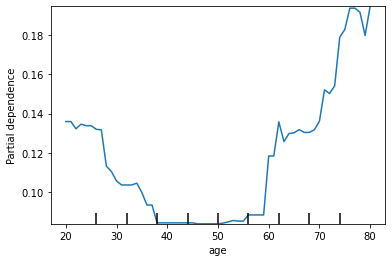

In [90]:
#Labels
labels=['age']

#PDP
plt.figure(figsize=(80,70))
PartialDependenceDisplay.from_estimator(gbm,X_train, labels)
plt.show()

We once again observe that the model captures a quadratic interaction between the age and the frequency. This curve should be compared with the one obtained with the regression tree and the random forest models. In particular, compared to the random forest, we have more *jumps* due to the fact that we use only 10 trees in the gradient boosting model (while we considered 20 trees in the random forest model).

We now look at the partial dependence between the power and the response.

<Figure size 5760x5040 with 0 Axes>

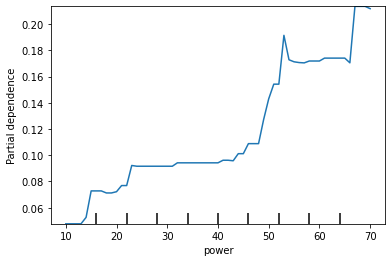

In [91]:
#Labels
labels=['power']

#PDP
plt.figure(figsize=(80,70))
PartialDependenceDisplay.from_estimator(gbm,X_train, labels)
plt.show()

The model also captures a kind of linear interaction between the power and the claims frequency.

Finally, let's plot the partial dependence between both features and the response.

<Figure size 5760x5040 with 0 Axes>

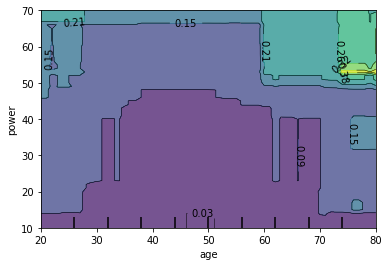

In [92]:
#Labels
labels=[('age', 'power')]

#PDP
plt.figure(figsize=(80,70))
pdp=PartialDependenceDisplay.from_estimator(gbm,X_train, labels)
plt.show()

It can be compared to the contour plot of the true relation between $\lambda$ and the features as presented in the first chapter.

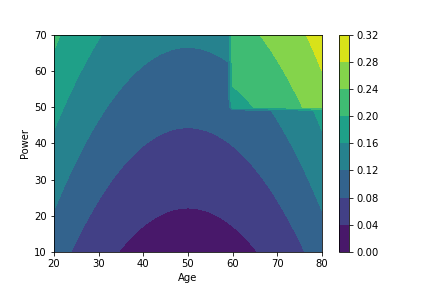

In [93]:
Image("www/freqs_contour.png")

Instead of looking at the contour plot, we can also compare the 3D plots. We first make the 3D plot of the partial dependence.

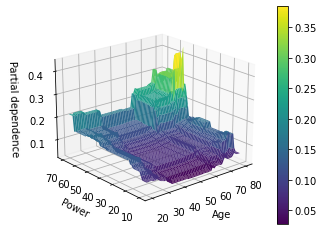

In [94]:
fig = plt.figure()

target_feature = (0, 1)
names = ["Age", "Power"]

pdp = partial_dependence(gbm, X_train, target_feature)

pdp_av=pdp['average']
axes = pdp['values']

#create a rectangular grid out of two given one-dimensional arrays
XX, YY = np.meshgrid(axes[0], axes[1])

Z = pdp_av.reshape(list(map(np.size, axes))).T #transpose of this matrix

ax =plt.subplot(projection="3d") #3D Axes

# Plot the surface
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.viridis)

#Label the axes
ax.set_xlabel(names[target_feature[0]])
ax.set_ylabel(names[target_feature[1]])
ax.set_zlabel('Partial dependence')

#Add a colorbar
ax.view_init(elev=20, azim=230) #used to rotate the axes programmatically
plt.colorbar(surf)

#Show the plot
plt.show()

We can compare it with the one of the first chapter.

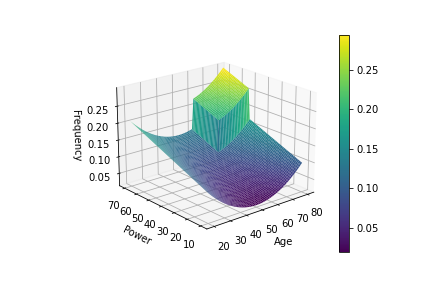

In [95]:
Image("www/freqs_3d.png")

## Chapter 6 - Next steps <a name="six"></a>

Here is the summary of the performance of our different models : 

| Model| Training set | Testing set |
| --- | --- | --- |
| Flat model |  0.5388 | 0.5543 |
| Reg Tree |  0.5223 | 0.5416 |
| Tuned Reg Tree |  0.5026 |  0.5210 |
| RF| 0.5033 | 0.5202 |
| Tuned RF| 0.5008 | 0.5200 |
| GBM| 0.5290 | 0.5425 |
| tuned GBM| 0.4996 | 0.5195 |
    

As we can see there isn't much of difference in terms of performance on the testing set between our 'tuned' models. The fact that our tuned RF and GBM cannot outperform a simple tuned regression tree shows that the tuning we did on the RF and GBM is clearly not the most optimal one. 

For both the random forest and the GBM we only optimized a single parameter : the min sample leaf and the number of trees respectively. But actually, it would have been better to optimize the following parameters at the same time (multidimensional tuning) : 

- Random forest : the min sample leaf and the number of trees in the forest
- GBM : the number of trees and the learning parameter

In the case of a random forest, increasing the number of trees in the forest allows to go deeper in the trees without overfitting. In the case of a GBM diminishing the learning parameter allows to add more trees without overfitting. 

In this notebook, the philosophy of tuning was presented but a proper optimal tuning is far more complex and requires to optimize at the same time many parameters.